In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly

In [68]:
returns = pd.read_csv("../data/weekly_returns.csv")
# returns = pd.read_csv("../data/weekly_prices.csv")

returns.Date = pd.DatetimeIndex(returns.Date)

returns.head()

,Date,ABEV3.SA,BBAS3.SA,BBDC4.SA,CPLE6.SA,CSAN3.SA,CSNA3.SA,ELET3.SA,ENBR3.SA,GGBR4.SA,ITUB4.SA,JBSS3.SA,PETR4.SA,SANB11.SA,SULA11.SA,TIMS3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
0,2010-01-04,0.038579,0.029609,0.018518,0.032145,-0.054668,0.039757,0.054168,0.056991,0.019789,0.008492,0.048339,0.007062,-0.019008,-0.010050,0.027588,0.042368,0.080260,-0.027216,0.054612
1,2010-01-11,0.019564,-0.019300,-0.026413,-0.014483,-0.010191,0.005033,-0.067417,0.047165,-0.023635,-0.045885,0.016924,-0.033015,-0.023733,-0.030363,-0.013699,-0.010875,-0.006713,-0.012511,-0.029853
2,2010-01-18,0.000125,-0.024574,-0.126901,-0.010667,-0.022880,-0.074748,0.154428,-0.023305,-0.102092,-0.027750,-0.055824,-0.028371,-0.053825,0.039236,-0.006921,-0.078553,-0.056576,-0.006652,-0.044017
3,2010-01-25,-0.058269,-0.015537,-0.014262,0.032704,-0.072430,0.025784,-0.047791,-0.019608,-0.027634,-0.003315,-0.025371,-0.016831,0.037092,-0.038828,-0.028171,0.064539,-0.032189,0.025804,0.002774
4,2010-02-01,-0.030459,-0.007142,-0.041713,-0.034313,0.094029,-0.012809,-0.507667,-0.044838,-0.026797,-0.037506,-0.035971,-0.080726,-0.106249,-0.044016,-0.049791,-0.039060,-0.036436,-0.030543,-0.048236


In [69]:
asset = returns[["Date","ABEV3.SA"]]

asset

,Date,ABEV3.SA
0,2010-01-04,0.038579
1,2010-01-11,0.019564
2,2010-01-18,0.000125
3,2010-01-25,-0.058269
4,2010-02-01,-0.030459
...,...,...
621,2021-11-29,-0.042221
622,2021-12-06,-0.003130
623,2021-12-13,0.007495
624,2021-12-20,-0.032894


In [70]:
asset = asset.rename(columns={"ABEV3.SA":'y',
                              'Date':'ds'})

asset

,ds,y
0,2010-01-04,0.038579
1,2010-01-11,0.019564
2,2010-01-18,0.000125
3,2010-01-25,-0.058269
4,2010-02-01,-0.030459
...,...,...
621,2021-11-29,-0.042221
622,2021-12-06,-0.003130
623,2021-12-13,0.007495
624,2021-12-20,-0.032894


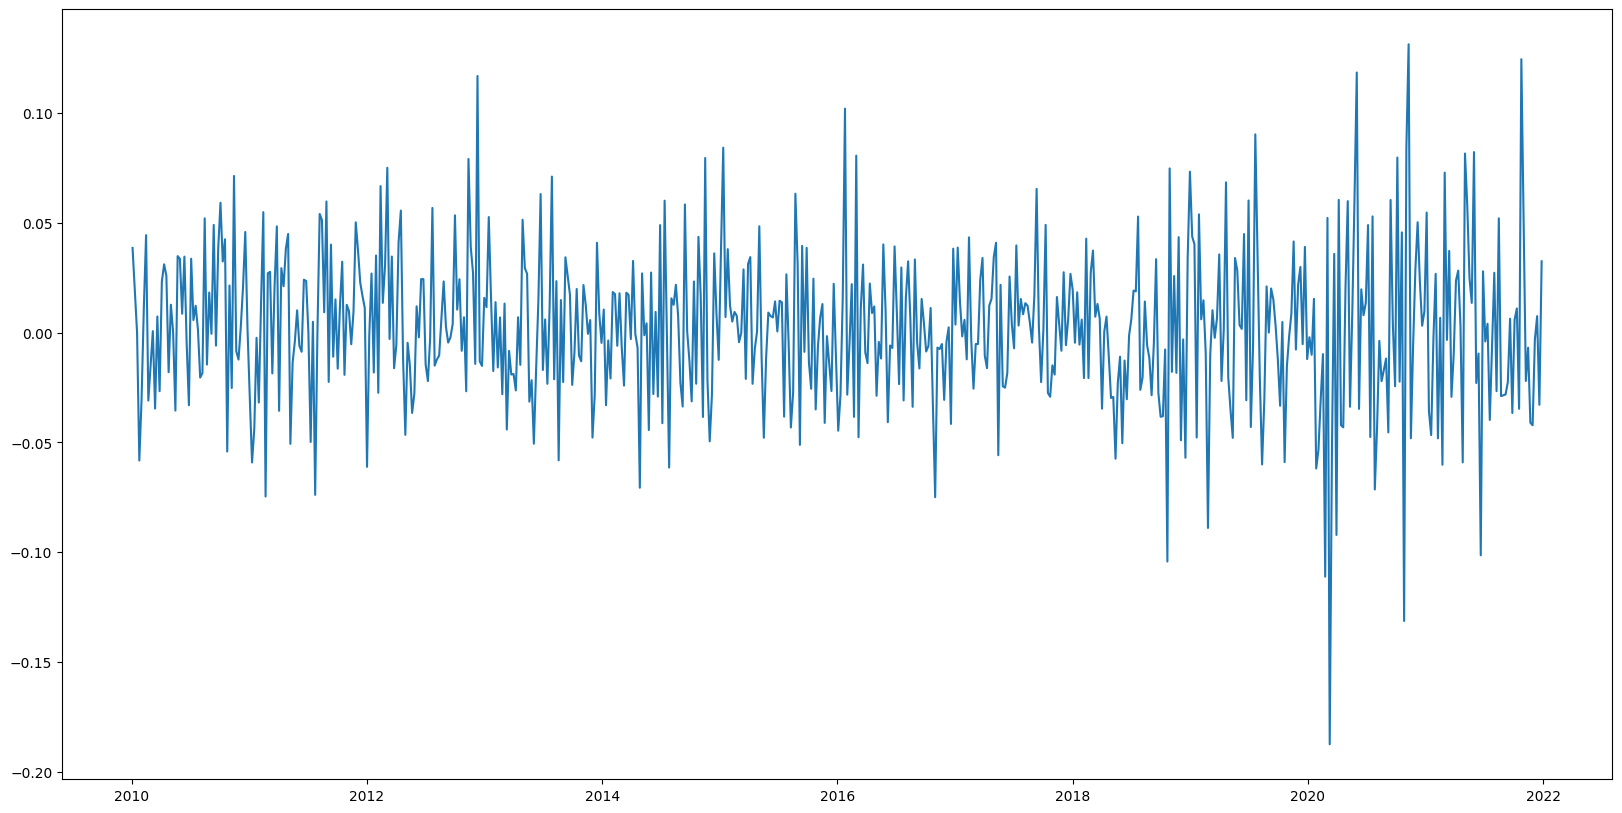

In [71]:
plt.figure(figsize=(20,10))
plt.plot(asset.ds,asset.y)
plt.show()

In [72]:
last_train_year = 2020 
test_year = 2021

train = asset[asset.ds.dt.year <= 2020]
test = asset[asset.ds.dt.year == 2021]

print(train.shape,test.shape)

(574, 2) (52, 2)


In [73]:
model = Prophet(growth="flat",
                n_changepoints = 10,
                weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True)
model.add_country_holidays(country_name="Brazil")

model.fit(train)

20:07:52 - cmdstanpy - INFO - Chain [1] start processing
20:07:52 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
future = model.make_future_dataframe(periods=52,freq='w')
forecast = model.predict(future)


future["yhat"] = forecast.yhat
future

,ds,yhat
0,2010-01-04,0.008220
1,2010-01-11,0.003269
2,2010-01-18,0.000659
3,2010-01-25,0.001388
4,2010-02-01,0.002948
...,...,...
621,2021-11-28,0.004668
622,2021-12-05,0.001510
623,2021-12-12,0.003326
624,2021-12-19,0.008348


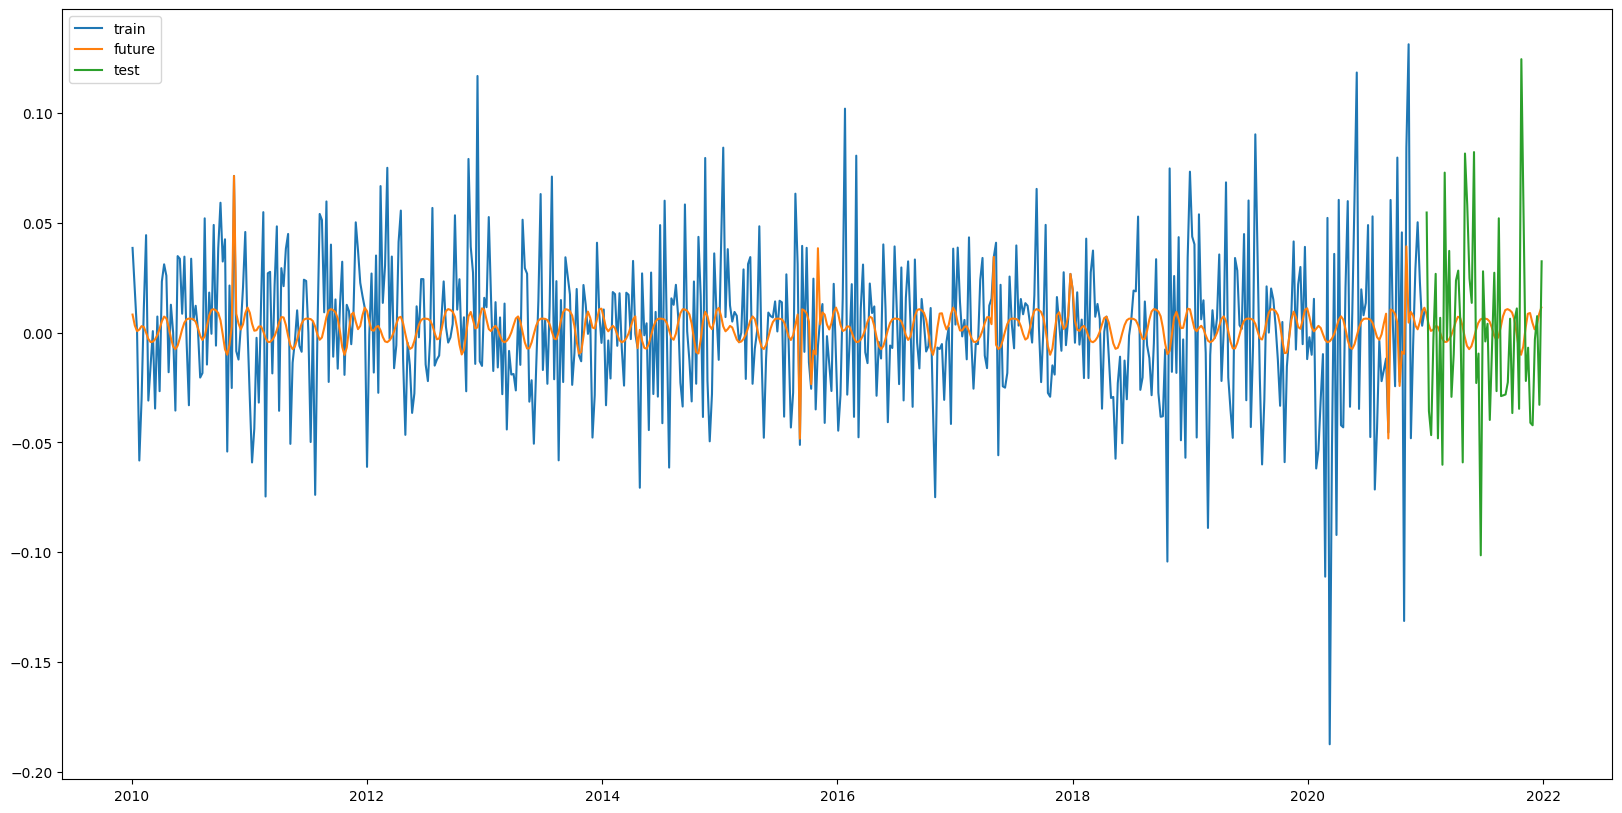

In [75]:
plt.figure(figsize=(20,10))
plt.plot(train.ds,train.y,label="train")
plt.plot(future.ds,future.yhat,label="future")
plt.plot(test.ds,test.y,label="test")
plt.legend()
plt.show()

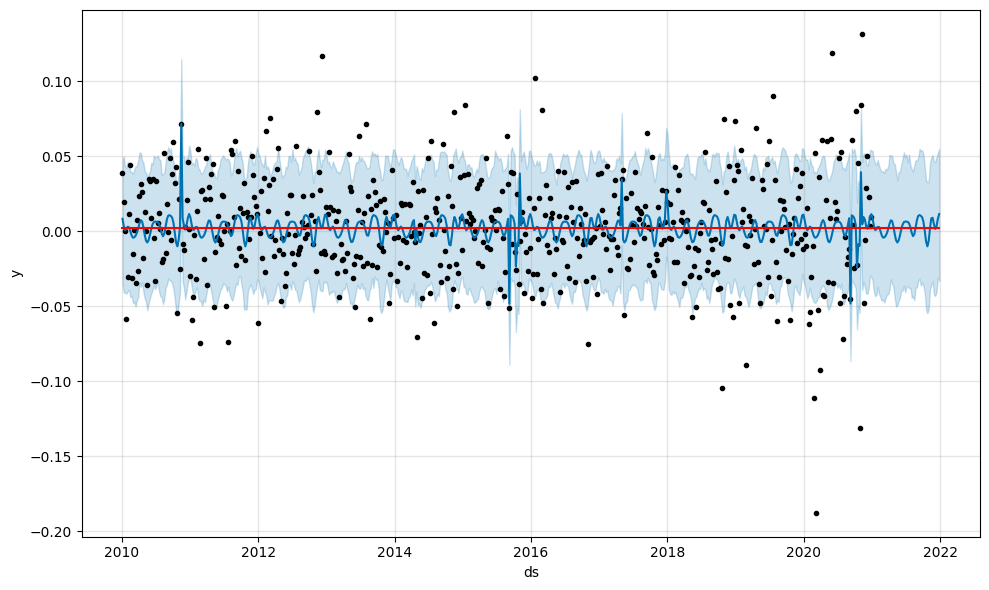

In [76]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [77]:
#rolling window

window = 14

days = train.ds
dict_prediction = {}

for i in range(window,len(days)):
    window_returns = asset[i-window:i]
    model = Prophet(growth="flat",
                    n_changepoints = 10,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True)
    model.add_country_holidays(country_name="BR")
    
    model.fit(window_returns)
    
    future = model.make_future_dataframe(periods=1,freq="w")

    prediction = model.predict(future)
    dict_prediction[str(future.values[window][0])] = prediction.yhat[window]/1 #por que?
    


20:07:54 - cmdstanpy - INFO - Chain [1] start processing
20:07:54 - cmdstanpy - INFO - Chain [1] done processing
20:07:54 - cmdstanpy - INFO - Chain [1] start processing
20:07:54 - cmdstanpy - INFO - Chain [1] done processing
20:07:55 - cmdstanpy - INFO - Chain [1] start processing
20:07:55 - cmdstanpy - INFO - Chain [1] done processing
20:07:55 - cmdstanpy - INFO - Chain [1] start processing
20:07:55 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] start processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] start processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] start processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1]

In [78]:
df_prediction = pd.DataFrame(index=dict_prediction.keys(),data=dict_prediction.values())                            

df_prediction.index = pd.to_datetime(df_prediction.index)

df_prediction.rename(columns={0:"PETR4.SA"},inplace=True)
df_prediction

,PETR4.SA
2010-04-11,0.008571
2010-04-18,0.039706
2010-04-25,0.037320
2010-05-02,-0.068632
2010-05-09,0.075206
...,...
2020-11-29,2.938001
2020-12-06,0.016636
2020-12-13,-0.220206
2020-12-20,0.123870


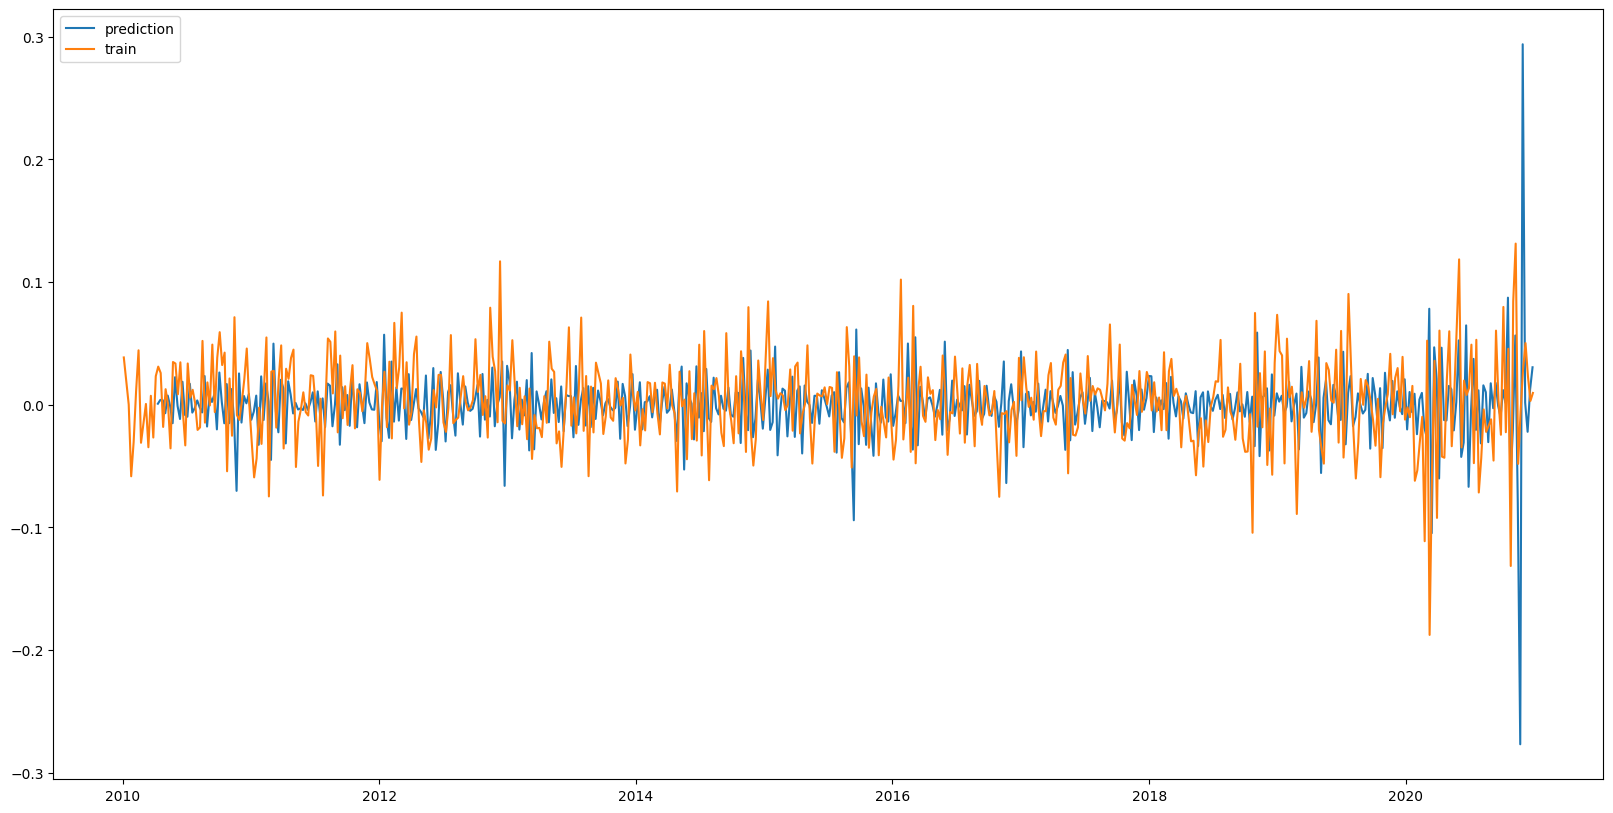

In [80]:
plt.figure(figsize=(20,10))
plt.plot(df_prediction/10,label="prediction")
plt.plot(train.ds,train.y,label="train")
plt.legend()
plt.show()